# you need to install these packages in your conda enviroment

In [1]:
#Install python packages in anaconda

# Install missiong pachages
# https://anaconda.org/anaconda/numpy
# https://anaconda.org/conda-forge/matplotlib
# https://anaconda.org/anaconda/pandas
# https://anaconda.org/anaconda/scipy

# conda install -c anaconda numpy
# conda install -c conda-forge matplotlib
# conda install -c anaconda pandas
# conda install -c anaconda scipy
# conda install -c anaconda astropy
# conda install -c conda-forge stingray

# conda install -c anaconda seaborn

# assuming all packages are installed, we load them
- note stingray has lots of packages for timing analysis and x-rays

In [1]:
import numpy as np
#from uncertainties import ufloat, unumpy
#from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

#from astropy.stats import LombScargle
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

import astropy.io.fits as pyfits

from stingray.pulse.search import epoch_folding_search, z_n_search

from scipy.signal import savgol_filter
import scipy.optimize

from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile

In [7]:
## some lines for stylish purposhes... try disabling them or commenting them out and see what changes in plots.

##specify notebook style, following lines help with interactive plots, i.e. show values as you hover mouse pointer
# plt.style.use('seaborn-notebook')
# %matplotlib notebook

## Next two lines help with setting max width on cell. 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Next 3 lines help with default color on plots, i.e. balck or white Backgorund color
import seaborn as sns
sns.set(context='notebook',style='dark')
plt.style.use(['dark_background'])

## Play with python plots of fits images

a fits file is essentially a table and some extra information
we care about table of data which is in extension "[1]" of the file, have a look on the file with topcat or ds9 as well

In [8]:
# we load a fits file
image_file1 = 'nu30202035002A01_cl.evt.gz'
imfits = pyfits.open(image_file1)

im = imfits[1].data

lest see which columns are in the table and print their context

In [9]:
print(im.dtype)

(numpy.record, [('TIME', '>f8'), ('PRIOR', '>f8'), ('NUMRISE', '>i4'), ('DENRISE', '>i4'), ('SUBFRM', '>i4'), ('PREPHAS', '>i2', (9,)), ('POSTPHAS', '>i2', (9,)), ('RESET', '>f8'), ('TRIGGERS', 'u1', (2,)), ('DET_ID', 'u1'), ('S_CAP', 'u1'), ('HWTRIG', 'u1'), ('RAWX', 'u1'), ('RAWY', 'u1'), ('MODE', 'u1'), ('STIM', 'u1'), ('UP', 'u1'), ('SHIELD', 'u1'), ('SHLD_T', 'u1'), ('SHLD_HI', 'u1'), ('STATUS', 'u1', (2,)), ('BADPOS', 'u1', (1,)), ('HOTPOS', 'u1', (1,)), ('RAWPHAS', '>i2', (9,)), ('OFFPHAS', '>f4', (9,)), ('TRPHAS', '>f4', (9,)), ('PHAS', '>f4', (9,)), ('GRADE', '>i2'), ('SWTRIG', 'u1', (9,)), ('PIS_GAIN', '>f4', (9,)), ('SURRPI', '>i4'), ('PI_CLC', '>f4'), ('PI', '>i4'), ('DET1X', '>i2'), ('DET1Y', '>i2'), ('DET2X', '>i2'), ('DET2Y', '>i2'), ('X', '>i2'), ('Y', '>i2')])


In [10]:
# this is an important column... more on this later
print(im['PI'])

[  32 3560 1379 ... 3443   25 1070]


TODO: In the next cell print the context of the columns that have the time information

In the next cell we like to plot a 2D histogram of number of pixels.
You can define a position of a photon by its CCD pixel coordinate and plot it like with ds9.

TODO: use the 'X' and 'Y' columns as x and y variables

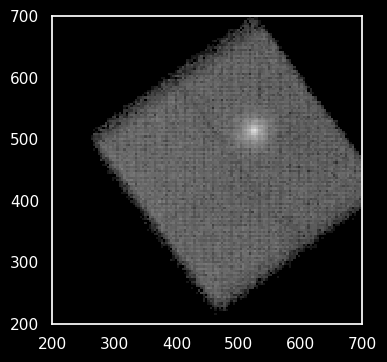

In [13]:
# you can define a position of a photon by its CCD pixel coordinate and plot it like with ds9
x = im['X']
y = im['Y']

plt.close('all')
fig1=plt.figure(1,figsize=(4,4))
plt.hist2d(x, y, bins=(200, 200),cmap=mpl.cm.gray,norm=mpl.colors.LogNorm())
plt.xlim(200,700)
plt.ylim(200,700)
plt.show()

In the above plot you see a point source round coordinates 500,500,

Here is a function to measure the distance of each photon from the central point
the funstion returns a table with equal size as the number of events you pass into the pable, and "True/False" values depending if the photon is inside or outside the radious.


In [12]:
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= radius ** 2

We call the above function using the center we find, e.g. 550,550 and a radious in pixel coordinates of 50 pixels

TODO: can you define the center and size/extend of the point source more accuratly?

In [14]:
dist = in_circle(550.0,550.0,50,x,y)

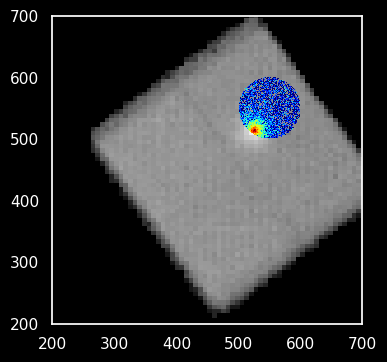

In [16]:
#here we plot the same image as above in grey scale, and the photons we selected in color scale.

plt.close('all')
fig1=plt.figure(1,figsize=(4,4))
plt.hist2d(x, y, bins=(100, 100),cmap=mpl.cm.gray,norm=mpl.colors.LogNorm())
plt.hist2d(x[dist], y[dist], bins=(100, 100), cmap=plt.cm.jet,norm=mpl.colors.LogNorm())
plt.xlim(200,700)
plt.ylim(200,700)
plt.show()

## Here we start the timing analysis

We can use photons/events that were detected inside the cyrcle defioned above

The PI column is calculated from the measure of the charge in the CCD camera created from each photon, and can be translated to energy in keV (cgs)
Nustar E = Channel Number * 0.04 keV + 1.6 keV

TODO: alter the limits in mask1 to include energies between 3 and 30 keV

In [22]:
times0 = im['time']
PI0=im['PI']
times = times0[dist]
PI = PI0[dist]


mask1 = (PI*0.04+1.6>3) & (PI*0.04+1.6<=30)
print(PI.min(), PI.max())

times_masked = times[mask1]

0 4095


## Merge data from 2 detectors (extra credit) 

by merging these 2 files we increase our statistics, but we have to merge the two lists
the two files are
nu30202035002A01_cl_sc_bary.fits
nu30202035002B01_cl_sc_bary.fits

you need to read them both and merge them in one list

hints...
- look at numpy append, or "np.append" command
- Do not forget to filter for energies, aka PI

In [23]:
## try here in class or try at home

# Pulsation search with epoch folding.

Let us assume we have already an estimate of the pulse period, for example because we found a candidate in the power density spectrum with a period of ~31.62 sec.
We search around that period with the epoch folding.

Epoch folding consists of cutting the light curve at every pulse period and summing up all the intervals obtained in this way. We get an average pulse profile. In this example, where the pulse was plotted twice for visual clarity. If the candidate pulse frequency was even slightly incorrect, we would have obtained a much shallower pulse profile, or no pulse profile at all.

TODO: here we use all events from detector (i.e. times array), you need to use only the masked times to increase signal-to-noise of the data.

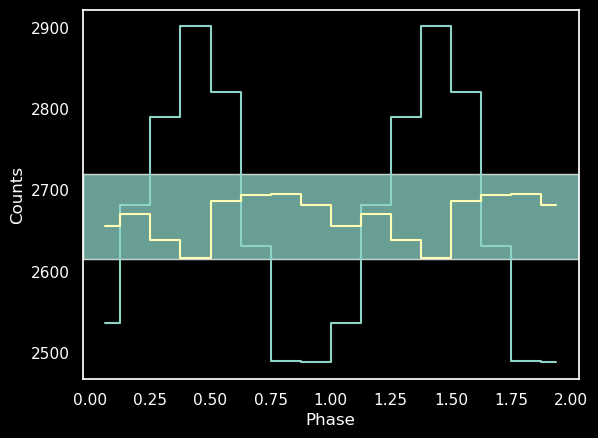

In [34]:
nbin = 8
period = 31.62

ph, profile, profile_err = fold_events(times, 1/period, nbin=nbin)
_ = plot_profile(ph, profile)


# plot folded profile for random period of 21 s
ph, profile, profile_err = fold_events(times, 1/21, nbin=nbin)
_ = plot_profile(ph, profile)

Therefore, typically we try a number of frequencies around the candidate we found with the power spectrum or other means, and search for the frequency that gives the "best" pulsed profile. 
How do we evaluate this best frequency?
We use the chi squared statistics. 

We use a flat pulsed profile (no pulsation) as model, and we calculate the chi square of the actual pulsed profile with respect to this flat model:

$$
S = \sum_i\frac{(P_i - \overline{P})^2}{\sigma^2}
$$

If there is no pulsation, the chi squared will assume a random value distributed around the number of degrees of freedom $n - 1$ (where $n$ is the number of bins in the profile) with a well defined statistical distribution ($\chi^2_{n - 1}$). If there is pulsation, the value will be much larger.
Stingray has a function that does this: `stingray.pulse.search.epoch_folding_search`.

For the frequency resolution of the periodogram, one usually chooses _at least_ the same frequency resolution of the FFT, i. e., $df_{\rm min}=1/(t_1 - t_0)$. In most cases, a certain degree of oversampling is used.

We will search for pulsations over a range of frequencies around the known pulsation period.
we search between a amximum and minimum period... ask us in the classroom why we define them these way.
the default step is 1/T where T is the duration of the observations. we can do more fine steps by increasing the oversampling parameter i.e. a value of 10 will give narrower range, and 0.1 a wider range

TODO: change oversample and see what happens

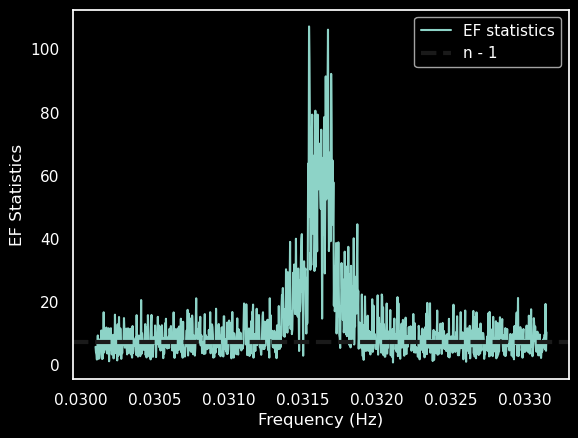

In [47]:
obs_length = times.max()-times.min()
df_min = 1/obs_length
oversampling=1
df = df_min / oversampling

frequencies = np.arange(1/period - 500 * df, 1/period + 500 * df, df)


freq, efstat = epoch_folding_search(times, frequencies, nbin=nbin)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, efstat, label='EF statistics')
plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
# plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Guess frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
_ = plt.legend()


Instead of using the epoch folding functions, we can define our own function to search for periodic signal.

A psudo code would be:
- give a time series as an input, together with a grid of frequencies and number of bins
- estimate phase of each photon, and create a histogram with 'np.histogram' function with N number of bins
- use your own statistical test, for example maximize standard deviation of bins (i.e. use function np.std(X))
- return the array for all input frequencies.

In [48]:

def phases(times,freq,bins):
    arr = []
    for i in range(len(freq)):
        phase_time = times%(1/freq[i])
        hist, bin_edges = np.histogram(phase_time,bins)
        stdev = np.std(hist)
        arr = np.append(arr,stdev)
    
    return arr

Lets try our function, you may try this in the masked events

In [49]:
times_ev = times - np.min(times)
bins=8
phase_test = phases(times_ev,frequencies,bins)

We can compare our method with the one from  the "black box" tool.. `epoch_folding_search`.

TODO: create a comparion plot of two methods:
- axis Folding statistics vs frequency
- add labels

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


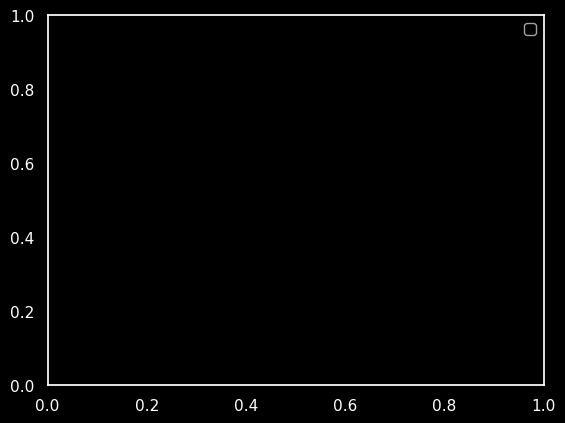

In [50]:

plt.figure()
#ADD CODE HERE
_ = plt.legend()

# Optional material: 

!! Do not read this during Lab !!

If you are interested in period search tests have a look here...

https://github.com/StingraySoftware/notebooks/blob/main/Pulsar/Pulsar%20search%20with%20epoch%20folding%20and%20Z%20squared.ipynb

# Z-squared search
The epoch folding statistics has no information on the actual shape of the profile. 

A better method is the **$Z^2$ statistics** (Buccheri et al. 1983), which is conceptually similar to the Epoch folding but has high values when the signal is well described by a small number of **sinusoidal harmonics**. 

$Z^2_n = \dfrac{2}{N} \sum_{k=1}^n \left[{\left(\sum_{j=1}^N \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^N \sin k \phi_j\right)}^2\right]$

Where $N$ is the number of photons, $n$ is the number of harmonics, $\phi_j$ are the phases corresponding to the event arrival times $t_j$ ($\phi_j = \nu t_j$, where $\nu$ is the pulse frequency).

The $Z_n^2$ statistics defined in this way, far from the pulsed profile, follows a $\chi^2_n$ distribution, where $n$ is the number of harmonics this time.

Stingray implements the $Z$ search in `stingray.pulse.search.z_n_search`.
The standard $Z^2$ search calculates the phase of each photon and calculates the sinusoidal functions above for each photon. This is very computationally expensive if the number of photons is high. Therefore, in Stingray, the search is performed by binning the pulse profile first and using the phases of the folded profile in the formula above, multiplying the squared sinusoids of the phases of the pulse profile by a weight corresponding to the number of photons at each phase.

$Z^2_n = \dfrac{2}{\sum_j{w_j}} \sum_{k=1}^n \left[{\left(\sum_{j=1}^m w_j \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^m w_j \sin k \phi_j\right)}^2\right]$

Since the sinusoids are only executed on a small number of bins, while the epoch folding procedure just consists of a very fast histogram-like operation, the speedup of this new formula is obvious. Care must be put into the choice of the number of bins, in order to maintain a good approximation even when the number of harmonics is high. As a rule of thumb, use _a number of bins at least 10 times larger than the number of harmonics_.

# # MAIN ANALYSIS PART

The power spectrum above looks strange, it has multiple peaks. This gives us a hint that there might be mupliple periodicitis, or that the period of the pulsar is changing in time.

# tasks
- create a light curve of the photons, use a large bin time
- split the lightcurve in small intervals with masks and search for a period in each interval
- plot the best period vs time, i.e. if you split the data into N segments, you will plot N periods versus the mean/middle of the segment

TODO: lets find what is the total duration of the observations, i.e. the time between the first and last event

TODO: make a plot
- create a histogram with number of bins that split the lightcurve into 1,10,100 or 1000 sec bins.
- Try to zoom in into a part of the light-curve, 
- Do you see some periodic features like gaps?
- knowing that the data come from NuSTAR, can you imagine what is the cause of these gaps? if not search some of the properties of satelite in the literature.

328080.2199728787


(0.0, 20000.0)

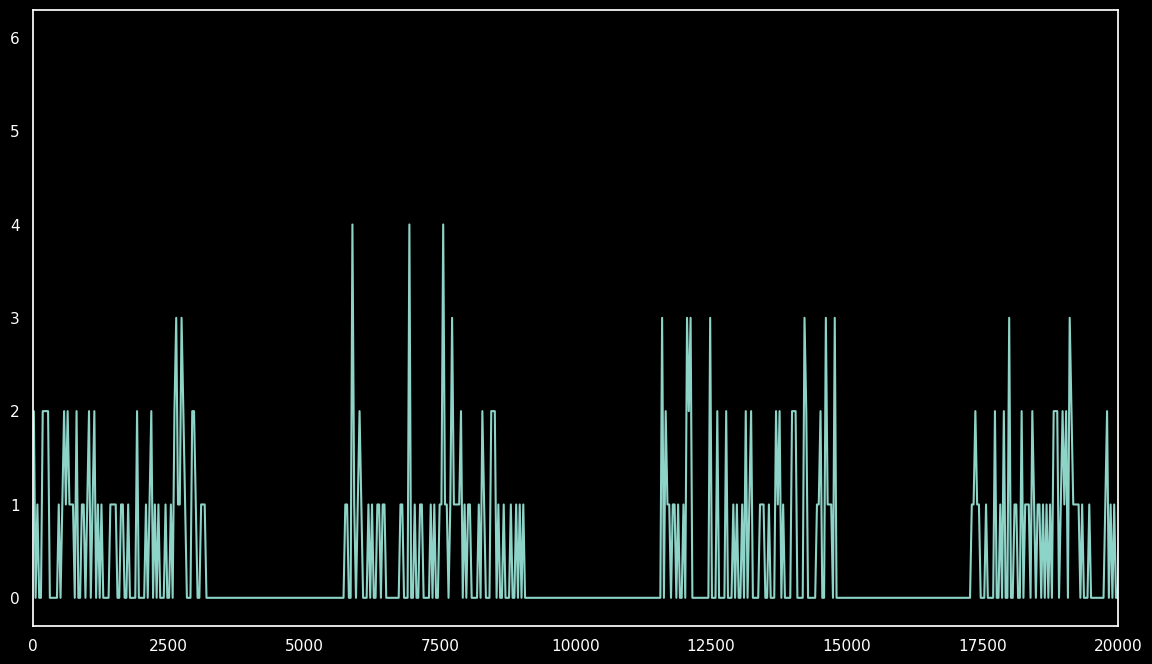

In [59]:
plt.close('all')
fig1=plt.figure(1,figsize=(14,8))

print(np.max(times1)-np.min(times1))

hist1, bin_edges1 = np.histogram(times1-np.min(times1), 10000)

# try creating a histogram with different number of bins, here i used a bin of ~1 sec
# hist1, bin_edges1 = np.histogram(times1-np.min(times1), )

# or you can try a bin size of ~100 seconds
#hist1, bin_edges1 = np.histogram(times1-np.min(times1), )

bin_mean1 = (bin_edges1[1:] + bin_edges1[0:-1])/2
plt.plot(bin_mean1,hist1)

# try to zoom in deferent time period...
# plt.xlim(0,20000)

In [64]:
# here we can run a mask and select events within a time period of the above plot.
# we can trey for the first 30 ks and last 30 ks.

# mask1 = (times_ev>0) & (times_ev<30000)
# mask2 = (times_ev>270000) & (times_ev<300000)
# mask3 = (times_ev>50000) & (times_ev<100000)

mask1 = (times_ev>0) & (times_ev<100000)
mask2 = (times_ev>100000) & (times_ev<200000)
mask3 = (times_ev>200000) & (times_ev<300000)

power_dt1 = phases(times_ev[mask1],frequencies,10)
power_dt2 = phases(times_ev[mask2],frequencies,10)
power_dt3 = phases(times_ev[mask3],frequencies,10)

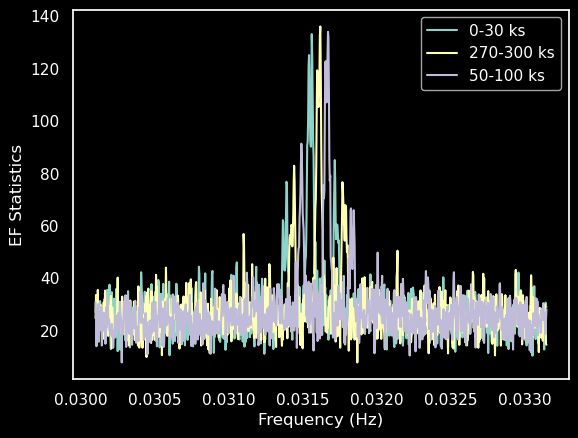

In [65]:
plt.figure()

plt.plot(frequencies, power_dt1, label='0-30 ks')
plt.plot(frequencies, power_dt2, label='270-300 ks')
plt.plot(frequencies, power_dt3, label='50-100 ks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
# plt.xlim(0.0312,0.0322)
_ = plt.legend()

In [66]:
#get frequencies of peaks
max_f1 = frequencies[np.argmax(power_dt1)]
max_f2 = frequencies[np.argmax(power_dt2)]
max_f3 = frequencies[np.argmax(power_dt3)]
print(max_f1,max_f2,max_f3)

0.03156155815310358 0.03161945865727215 0.031671264371528236


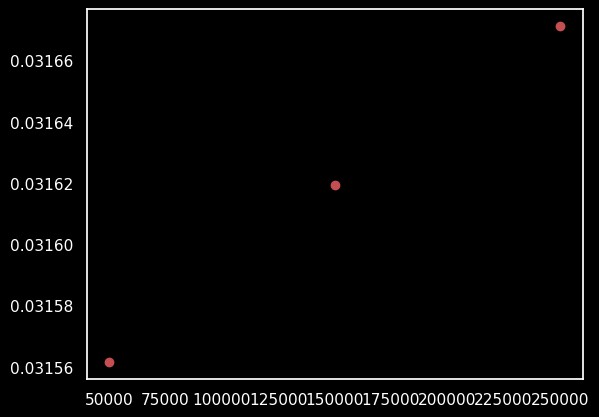

In [69]:

# Crete array of times and frequencies
T = [np.mean(times_ev[mask1]),np.mean(times_ev[mask2]),np.mean(times_ev[mask3])]

F = [max_f1,max_f2,max_f3]

plt.close('all')
plt.plot(T,F,'ro')
# add axis with labels... 

In [70]:
# We can fit a line
#define a function and using the curve fit functions, which returns best fit an a matrix for "errors".
# The variance of parameters are the diagonal elements of the variance-co variance matrix, and the standard error is the square root of it

def lin(x, a, b):
    x = np.array(x)
    return a*x + b

fit_params, pcov = scipy.optimize.curve_fit(lin,T,F)

print('best fit:',fit_params)
print('errors:',np.sqrt(np.diag(pcov)))

x_fit = [np.min(T),np.max(T)]
y_fit = lin(x_fit, *fit_params)

best fit: [5.48041164e-10 3.15351383e-02]
errors: [1.62938240e-11 2.78547374e-06]


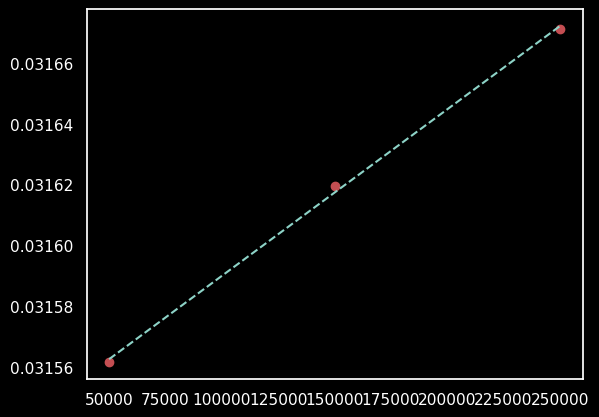

In [71]:
#lets have a look at the fit...
plt.close('all')
plt.plot(T,F,'ro')
plt.plot(x_fit,y_fit,'--')

#